In [24]:
import numpy as np
from numpy.random import multivariate_normal
import scipy as scp
import sklearn
from scipy.sparse.csgraph import laplacian as sp_laplacian
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import mutual_info_score as mi
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

N_SAMPLES = 1000

In [2]:
def get_synth_data():
    c1_means = [[1, 1],[1, 2],[1, 1]]
    c2_means = [[3, 4],[2, 2],[3, 3]]
    c1_cov = list()
    c1_cov.append([[1, 0.5],[0.5, 1.5]])
    c1_cov.append([[1, -0.2],[-0.2, 1]])
    c1_cov.append([[1.2, 0.2],[0.2, 1]])
    c2_cov = list()
    c2_cov.append([[0.3, 0.2],[0.2, 0.6]])
    c2_cov.append([[0.6, 0.1],[0.1, 0.5]])
    c2_cov.append([[1, 0.4],[0.4, 0.7]])
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    v_data =  [[],[],[]]
    
    for co in range(2):
        for vi in range(3):
            samples = multivariate_normal(means[co][vi], cov[co][vi], N_SAMPLES)
            v_data[vi].append(samples)
            
    for vi in range(3):
        v_data[vi] = np.vstack(v_data[vi])
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    for vi in range(3):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

In [3]:
def get_synth_data2():
    c1_means = [[-3, 1],[-5, 2],[-9, 1]]
    c2_means = [[3, 4],[2, 2],[3, 3]]
    c1_cov = list()
    c1_cov.append([[1, 0.5],[0.5, 1.5]])
    c1_cov.append([[1, -0.2],[-0.2, 1]])
    c1_cov.append([[1.2, 0.2],[0.2, 1]])
    c2_cov = list()
    c2_cov.append([[0.3, 0.2],[0.2, 0.6]])
    c2_cov.append([[0.6, 0.1],[0.1, 0.5]])
    c2_cov.append([[1, 0.4],[0.4, 0.7]])
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    v_data =  [[],[],[]]
    
    for co in range(2):
        for vi in range(3):
            samples = multivariate_normal(means[co][vi], cov[co][vi], N_SAMPLES)
            v_data[vi].append(samples)
            
    for vi in range(3):
        v_data[vi] = np.vstack(v_data[vi])
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    for vi in range(3):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

In [4]:
v_data, labels = get_synth_data()

In [ ]:
def gaussian_sim(X_mat):
    
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    sq_dists = np.square(distances)
    #mask = (np.eye(distances.shape[0]) != 1)
    norm_dists = sq_dists  / (2 * np.median(sq_dists))
    sims = np.exp(-norm_dists)
    
    #Set elements in the diagonal to 0
    #for ind in range(samples):
    #    sims[ind, ind] = 0
    
    return sims
    
def sym(S_mat):
    mat =  (S_mat + np.transpose(S_mat))/2
    return mat + np.min(mat)

def comp_laplacian(X_mat):
    D_mat = np.diag(np.sum(X_mat, axis=1))
    D_alt = np.sqrt(np.linalg.inv(D_mat)) 
    laplacian = D_alt @ X_mat @ D_alt
    return laplacian

def comp_eigs(X_mat, k):
    laplacian = comp_laplacian(X_mat)
    e_vals, e_vecs = np.linalg.eig(laplacian)
    indices = np.argsort(e_vals)[-k:]
    e_vecs = e_vecs[:,indices]
    return e_vecs


    

In [6]:
def multiview_spectral(v_data, labels, k=2, num_iter = 5):
    #Compute the similarities matrices
    sims = [gaussian_sim(dat) for dat in v_data]
    
    #Initialize matrices of eigenvectors
    U_mats = [comp_eigs(sim, k) for sim in sims]
    
    #Iteratively compute new graph similarities, laplacians, and eigenvectors
    for iter in range(num_iter):
        print(iter)
        new_sims = list()
        mat1 = U_mats[1] @ np.transpose(U_mats[1]) @ sims[0]
        new_sims.append(sym(mat1))
        mat2 = U_mats[0] @ np.transpose(U_mats[0]) @ sims[1]
        new_sims.append(sym(mat2))
        sims = new_sims
        U_mats = [comp_eigs(sim, k) for sim in sims]    
    #Row normalize 
    for view in range(len(v_data)):
        min_rows = np.min(U_mats[view], axis=1).reshape((-1, 1))
        max_rows = np.max(U_mats[view], axis=1).reshape((-1, 1))
        U_mats[view] = (U_mats[view] - min_rows) / (max_rows - min_rows)
    #Columnwise concatenation across all views
    V_mat = np.hstack(U_mats)    
    kmeans = KMeans(n_clusters=k, n_init=100)
    clusters = kmeans.fit_predict(V_mat)
    return clusters
    

In [7]:
clusters = multiview_spectral(v_data[:2], labels, k=2)


[[1.48527928e-03 8.38616299e-04 3.33698517e-04 ... 5.57992109e-05
  5.22463718e-04 3.22997383e-04]
 [8.38616299e-04 1.11457232e-03 7.59265653e-04 ... 2.26447325e-04
  7.32571539e-04 5.25154484e-04]
 [3.33698517e-04 7.59265653e-04 8.72197371e-04 ... 5.20175822e-04
  6.96991290e-04 6.30600876e-04]
 ...
 [5.57992109e-05 2.26447325e-04 5.20175822e-04 ... 8.25492664e-04
  3.68245771e-04 4.72445430e-04]
 [5.22463718e-04 7.32571539e-04 6.96991290e-04 ... 3.68245771e-04
  7.87251567e-04 7.14886159e-04]
 [3.22997383e-04 5.25154484e-04 6.30600876e-04 ... 4.72445430e-04
  7.14886159e-04 7.40258836e-04]]
[[0.00069896 0.00056223 0.00058911 ... 0.00069279 0.00068559 0.00068436]
 [0.00056223 0.00072936 0.00056384 ... 0.00058723 0.00041778 0.00049963]
 [0.00058911 0.00056384 0.00081899 ... 0.00059398 0.00057783 0.0004632 ]
 ...
 [0.00069279 0.00058723 0.00059398 ... 0.00069063 0.00065888 0.0006717 ]
 [0.00068559 0.00041778 0.00057783 ... 0.00065888 0.00080882 0.00068059]
 [0.00068436 0.00049963 0.0004

4
[[0.00047192+4.00549529e-37j 0.00051884+2.83030529e-36j
  0.00047511-9.69750024e-37j ... 0.0004458 -4.28592306e-36j
  0.00046084-2.62593249e-36j 0.00046654-2.91887386e-36j]
 [0.00051884+2.83030529e-36j 0.00065895+1.86511442e-36j
  0.00047238-1.41909045e-37j ... 0.0003099 -1.55421491e-36j
  0.00039074-8.51114698e-37j 0.00038283-8.30127824e-37j]
 [0.00047511-9.69750024e-37j 0.00047238-1.41909045e-37j
  0.00050212+2.33148961e-38j ... 0.00054128+2.84028739e-37j
  0.00052231+1.72807607e-37j 0.0005343 +1.38872852e-37j]
 ...
 [0.0004458 -4.28592306e-36j 0.0003099 -1.55421491e-36j
  0.00054128+2.84028739e-37j ... 0.00076844+1.77943205e-36j
  0.0006564 +1.07002710e-36j 0.00068694+9.45056987e-37j]
 [0.00046084-2.62593249e-36j 0.00039074-8.51114698e-37j
  0.00052231+1.72807607e-37j ... 0.0006564 +1.07002710e-36j
  0.00059042+6.49991886e-37j 0.00061173+5.71548233e-37j]
 [0.00046654-2.91887386e-36j 0.00038283-8.30127824e-37j
  0.0005343 +1.38872852e-37j ... 0.00068694+9.45056987e-37j
  0.00061173

C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [8]:
score = nmi(labels, clusters)
print(score)

0.2757345676782332


In [9]:
score = f1_score(labels, clusters)
print(score)

0.7680491551459293


In [10]:
print()
print(clusters.sum())


1604


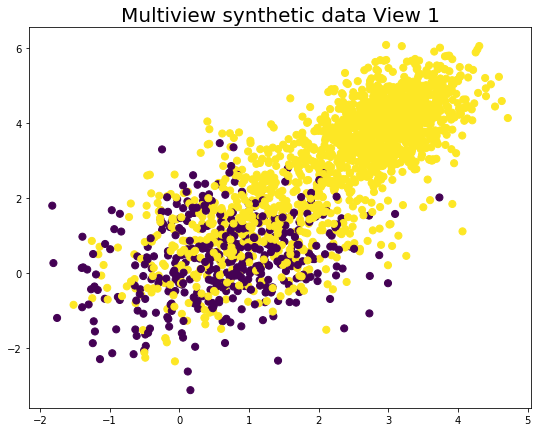

In [11]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview synthetic data View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=clusters,s=dot_size, cmap=cmap)

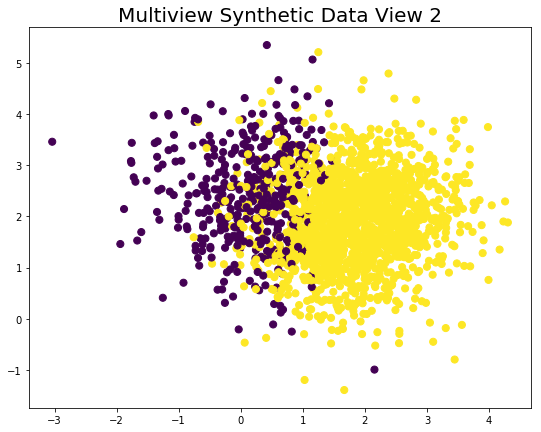

In [12]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview Synthetic Data View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=clusters,s=dot_size, cmap=cmap)

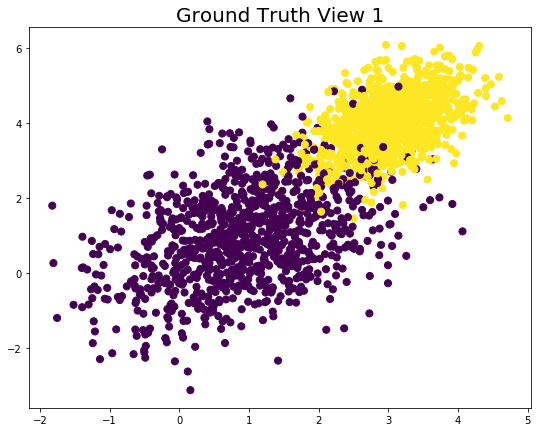

In [13]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=labels,s=dot_size, cmap=cmap)

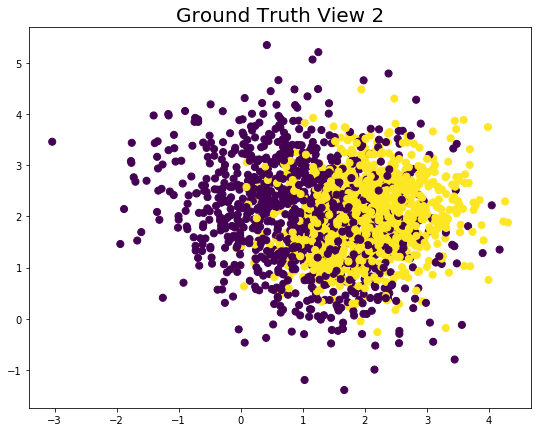

In [14]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=labels,s=dot_size, cmap=cmap)

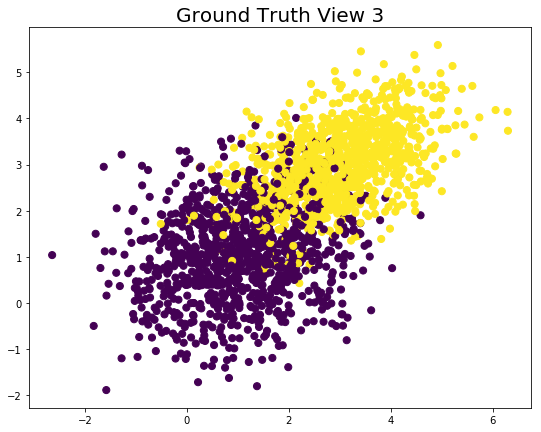

In [15]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 3', size=20)
ax.scatter(v_data[2][:, 0], v_data[2][:, 1],c=labels,s=dot_size, cmap=cmap)

In [16]:
def get_dist(X_mat):
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    return distances

distances = get_dist(v_data[0])
mask = (np.eye(distances.shape[0]) != 1)
g= 1/ (2 * np.median(distances[mask]) **2)
print(g)
cluster = SpectralClustering(n_clusters=2, gamma = g, n_jobs = -1)
pred = cluster.fit(v_data[0])
affinity = cluster.affinity_matrix_
aff = gaussian_sim(v_data[0])
print(affinity)
print(aff)

0.08761521723803466
[[1.         0.65211118 0.29360504 ... 0.05056836 0.48357437 0.30845998]
 [0.65211118 1.         0.770308   ... 0.23647582 0.7822823  0.57851993]
 [0.29360504 0.770308   1.         ... 0.61338578 0.84129967 0.78501503]
 ...
 [0.05056836 0.23647582 0.61338578 ... 1.         0.4572153  0.60472508]
 [0.48357437 0.7822823  0.84129967 ... 0.4572153  1.         0.93652965]
 [0.30845998 0.57851993 0.78501503 ... 0.60472508 0.93652965 1.        ]]
[[1.         0.65178612 0.29318573 ... 0.05039267 0.48316482 0.30803718]
 [0.65178612 1.         0.77007361 ... 0.23607851 0.78205833 0.57815083]
 [0.29318573 0.77007361 1.         ... 0.61303626 0.84113014 0.78479347]
 ...
 [0.05039267 0.23607851 0.61303626 ... 1.         0.45679821 0.60437048]
 [0.48316482 0.78205833 0.84113014 ... 0.45679821 1.         0.93645804]
 [0.30803718 0.57815083 0.78479347 ... 0.60437048 0.93645804 1.        ]]


In [18]:
#Single view scikit learn results 

#View 1
distances1 = get_dist(v_data[0])
g1= 1/ (2 * np.median(distances1) **2)
S_Cluster = SpectralClustering(n_clusters=2, gamma = g1)
v1_clusters = S_Cluster.fit_predict(v_data[0]) 
v1_score = nmi(labels, v1_clusters)
print("NMI for view 1 is " + str(v1_score))


#View 2
distances2 = get_dist(v_data[1])
g2= 1/ (2 * np.median(distances2) **2)
S_Cluster = SpectralClustering(n_clusters=2, gamma = g2)
v2_clusters = S_Cluster.fit_predict(v_data[1]) 
v2_score = nmi(labels, v2_clusters)
print("NMI for view 2 is " + str(v2_score))


#View 3
distances3 = get_dist(v_data[2])
g3= 1/ (2 * np.median(distances3) **2)
S_Cluster = SpectralClustering(n_clusters=2, gamma = g3)
v3_clusters = S_Cluster.fit_predict(v_data[2]) 
v3_score = nmi(labels, v3_clusters)
print("NMI for view 3 is " + str(v3_score))


NMI for view 1 is 0.6835811720956251
NMI for view 2 is 0.17235587998302934
NMI for view 3 is 0.5184514561882001


In [19]:
U_SAMPLES = 200

def get_dist(X_mat):
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    return distances

def get_UCI():
    
    fac_file = 'fac.txt'
    fou_file = 'fou.txt'
    fac_feats = np.loadtxt(fac_file, delimiter=',')
    fou_feats = np.loadtxt(fou_file, delimiter=',')
    v_data = [fou_feats, fac_feats]
    
    labels = list()
    for ind in range(10):
        labels.append(np.ones(U_SAMPLES,) * ind)
    labels = np.concatenate(labels)
    print(labels.shape)
    
        
    shuffle_inds = np.random.permutation(U_SAMPLES* 10)
    for vi in range(2):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    return v_data, labels

In [20]:
v_data, labels = get_UCI()

(2000,)


In [21]:
#Single view scikit learn results 

#View 1
distances1 = get_dist(v_data[0])
g1= 1/ (2 * np.median(distances1) **2)
S_Cluster = SpectralClustering(n_clusters=10, gamma = g1)
v1_clusters = S_Cluster.fit_predict(v_data[0]) 
v1_score = nmi(labels, v1_clusters)
print("NMI for view 1 is " + str(v1_score))


#View 2
distances2 = get_dist(v_data[1])
g2= 1/ (2 * np.median(distances2) **2)
S_Cluster = SpectralClustering(n_clusters=10, gamma = g2)
v2_clusters = S_Cluster.fit_predict(v_data[1]) 
v2_score = nmi(labels, v2_clusters)
print("NMI for view 2 is " + str(v2_score))

NMI for view 1 is 0.8665450527042016
NMI for view 2 is 0.5957644264542608


In [34]:
clusters = multiview_spectral(v_data, labels, k=10)
score = nmi(labels, clusters)
print(score)

[[7.79585393e-04 3.45204432e-04 6.87493842e-04 ... 1.45855145e-04
  7.36371264e-04 7.40779419e-04]
 [3.45204432e-04 8.44241349e-04 4.76070193e-04 ... 7.69449974e-04
  2.30372032e-04 3.41787205e-04]
 [6.87493842e-04 4.76070193e-04 7.67908607e-04 ... 2.46432017e-04
  6.10430145e-04 6.90487428e-04]
 ...
 [1.45855145e-04 7.69449974e-04 2.46432017e-04 ... 1.19950817e-03
  7.74098157e-05 1.44424428e-04]
 [7.36371264e-04 2.30372032e-04 6.10430145e-04 ... 7.74098157e-05
  8.46997346e-04 7.40797314e-04]
 [7.40779419e-04 3.41787205e-04 6.90487428e-04 ... 1.44424428e-04
  7.40797314e-04 7.82766675e-04]]
[[0.0007855  0.00059614 0.00059324 ... 0.00060464 0.00039815 0.00066483]
 [0.00059614 0.0007142  0.00057103 ... 0.00055504 0.00051539 0.00056315]
 [0.00059324 0.00057103 0.00074659 ... 0.00058524 0.00050845 0.00049314]
 ...
 [0.00060464 0.00055504 0.00058524 ... 0.00076179 0.00039862 0.0005787 ]
 [0.00039815 0.00051539 0.00050845 ... 0.00039862 0.00082734 0.00029512]
 [0.00066483 0.00056315 0.0004

[[0.00051588-1.49872080e-35j 0.00050396+7.99512267e-36j
  0.00051017-1.42158363e-35j ... 0.00051272+2.41566917e-36j
  0.00049068+6.87614428e-37j 0.00051013-1.79638360e-35j]
 [0.00050396+7.99512267e-36j 0.00050994-4.42041355e-36j
  0.00050196-5.27096608e-36j ... 0.00049908+2.50023148e-35j
  0.00050196-7.34689501e-36j 0.00049834+6.39440423e-36j]
 [0.00051017-1.42158363e-35j 0.00050196-5.27096608e-36j
  0.00050971-1.62288975e-35j ... 0.00050786+1.90141330e-36j
  0.0004905 +1.16132483e-36j 0.00050291-2.17770238e-35j]
 ...
 [0.00051272+2.41566917e-36j 0.00049908+2.50023148e-35j
  0.00050786+1.90141330e-36j ... 0.00053384+2.68467061e-35j
  0.00048319+2.25605083e-35j 0.00050603-1.36933120e-36j]
 [0.00049068+6.87614428e-37j 0.00050196-7.34689501e-36j
  0.0004905 +1.16132483e-36j ... 0.00048319+2.25605083e-35j
  0.00051257+1.59568960e-35j 0.00048712-1.22973140e-35j]
 [0.00051013-1.79638360e-35j 0.00049834+6.39440423e-36j
  0.00050291-2.17770238e-35j ... 0.00050603-1.36933120e-36j
  0.00048712-1

C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


0.8377713540922173


In [35]:
tsne = TSNE()
new_data_1 = tsne.fit_transform(v_data[0])
new_data_2 = tsne.fit_transform(v_data[1])

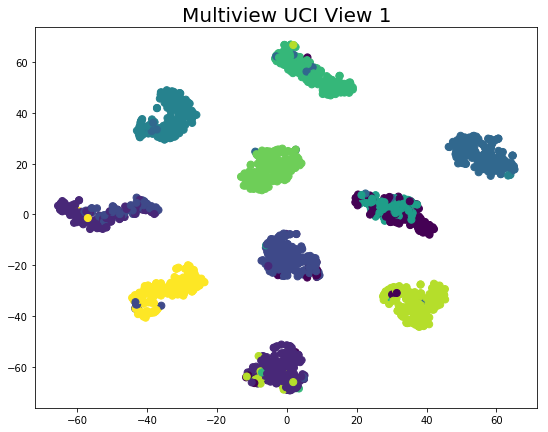

In [36]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview UCI View 1', size=20)
ax.scatter(new_data_1[:, 0], new_data_1[:, 1],c=clusters,s=dot_size, cmap=cmap)

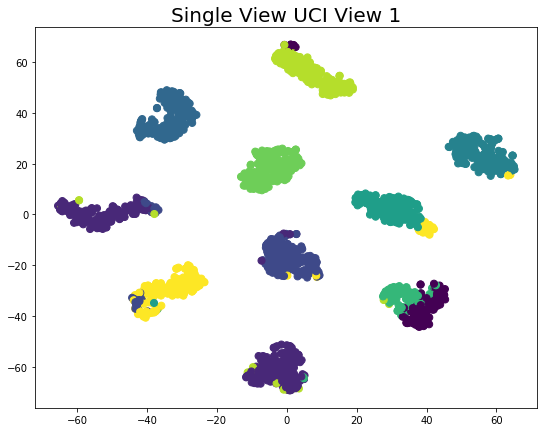

In [37]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Single View UCI View 1', size=20)
ax.scatter(new_data_1[:, 0], new_data_1[:, 1],c=v1_clusters,s=dot_size, cmap=cmap)

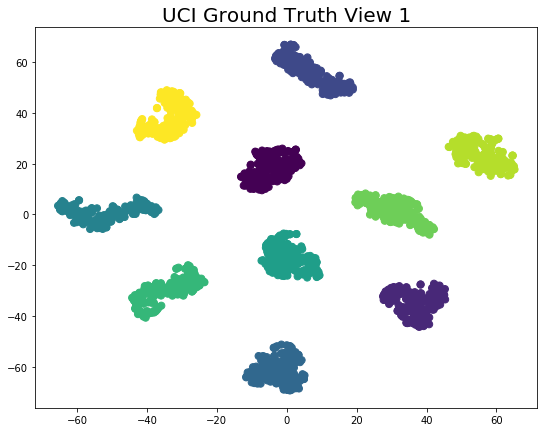

In [38]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('UCI Ground Truth View 1', size=20)
ax.scatter(new_data_1[:, 0], new_data_1[:, 1],c=labels,s=dot_size, cmap=cmap)

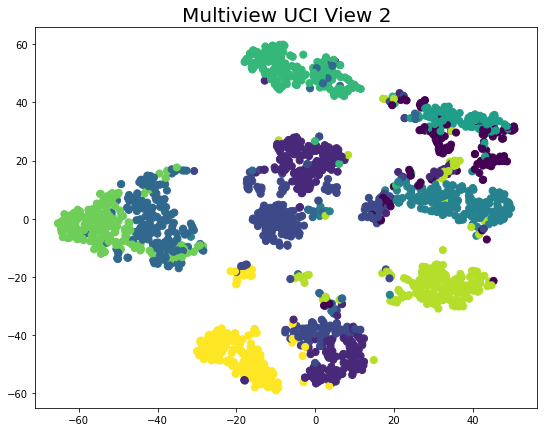

In [39]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview UCI View 2', size=20)
ax.scatter(new_data_2[:, 0], new_data_2[:, 1],c=clusters,s=dot_size, cmap=cmap)

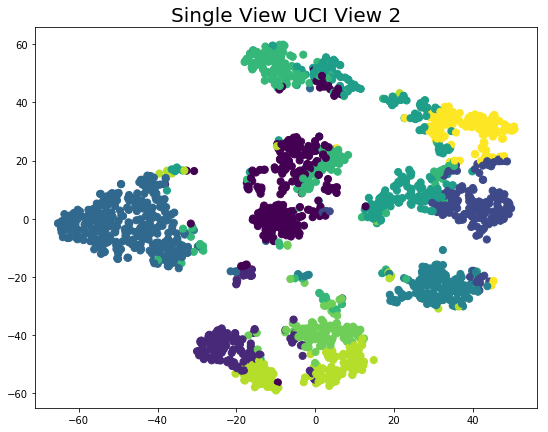

In [40]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Single View UCI View 2', size=20)
ax.scatter(new_data_2[:, 0], new_data_2[:, 1],c=v2_clusters,s=dot_size, cmap=cmap)

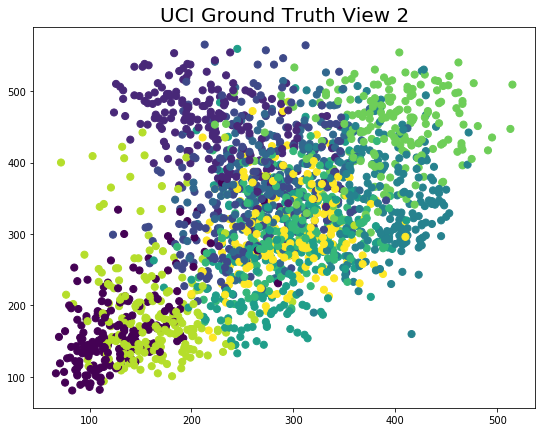

In [41]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('UCI Ground Truth View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=labels,s=dot_size, cmap=cmap)